In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
sns.set_palette("Set2")

## 1. 데이터 로딩 / データのロード

- Data can be obtained from the following sites.
- https://www.kaggle.com/CooperUnion/anime-recommendations-database

### Master table of animation

In [2]:
anime_df = pd.read_csv("anime.csv").sort_values(by="anime_id").reset_index(drop=True)
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,1,8.40,137636
2,6,Trigun,"Action, Comedy, Sci-Fi",TV,26,8.32,283069
3,7,Witch Hunter Robin,"Action, Drama, Magic, Mystery, Police, Superna...",TV,26,7.36,64905
4,8,Beet the Vandel Buster,"Adventure, Fantasy, Shounen, Supernatural",TV,52,7.06,9848


### Animation evaluation history for each user

In [3]:
ratings_df = pd.read_csv("rating.csv")
ratings_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## 2. 데이터 전처리 / データの前処理

### Animation Info.

- Because the string "unknown" exists, the episodes column is set to object type.

In [4]:
anime_df["episodes"].unique()[:20]

array(['26', '1', '52', '145', '24', '74', '220', 'Unknown', '178', '12',
       '22', '69', '25', '4', '94', '5', '3', '13', '23', '43'],
      dtype=object)

- Replace "unknown" with -1 and change to int type.

In [5]:
anime_df["episodes"] = anime_df["episodes"].replace("Unknown", -1).astype("int64")

### Rating Data

- -1's rating value means that the animation has been viewed but not evaluated.
- Conversion to the NaN makes it impossible to distinguish between unseen and unevaluated.
- As an alternative, -1 is converted to the average rating of the animation.

In [6]:
ratings_df = pd.merge(ratings_df, anime_df[["anime_id", "rating"]], on="anime_id", how="left", suffixes=["", "_avg"])
ratings_df["rating_mod"] = ratings_df["rating"]
ratings_df.loc[ratings_df["rating_mod"] == -1, "rating_mod"] = ratings_df["rating_avg"]
ratings_df.head()

,user_id,anime_id,rating,rating_avg,rating_mod
0,1,20,-1,7.81,7.81
1,1,24,-1,8.06,8.06
2,1,79,-1,7.31,7.31
3,1,226,-1,7.85,7.85
4,1,241,-1,6.69,6.69


### User × Item cross tabulation

In [7]:
features_df = ratings_df.pivot_table(index=["user_id"], columns=["anime_id"], values="rating_mod").fillna(0)
features_df.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34283,34324,34325,34349,34358,34367,34412,34475,34476,34519
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,8.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,8.00,0.0,0.0,6.0,0.0,6.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. 탐색적 데이터 분석 / 探索的データ解析

### The Number of members top 10 animation

In [8]:
anime_df.sort_values(by="members", ascending=False)[:10]

,anime_id,name,genre,type,episodes,rating,members
1393,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
7466,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
6626,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
3974,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
4640,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
1431,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
10,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
5689,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
6306,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
3566,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


### Total rating distribution

- Exclude null values present in the rating column.
- Fewer members make it less reliable, so only animations with more than 5000 members are extracted.
- The "Kimi no Na wa."（君の名は）has the highest rating.

In [9]:
anime_rating = anime_df.loc[(anime_df["rating"].notnull()) & (anime_df["members"] >= 5000), :]
anime_rating.sort_values(by="rating", ascending=False).head()

,anime_id,name,genre,type,episodes,rating,members
11333,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
3974,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
9934,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
5689,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
6015,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


- Only a few animations with 9 or more rating.
- There are more than half of the animations in the seven-point range.

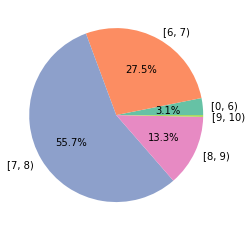

In [10]:
anime_rating_count = pd.cut(anime_rating["rating"], [0, 6, 7, 8, 9, 10], right=False).value_counts().sort_index()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(anime_rating_count.values, labels=anime_rating_count.index, autopct=lambda x: "{:.1f}%".format(x) if x >= 3 else "")
plt.show()

### Distribution of number of episodes

- Most movie and OVA have 1 episode, so limit to TV animation.
- 12 and 13 eposiodes（=1쿨/1クール） are main.

In [11]:
anime_episodes = anime_df.loc[(anime_df["type"] == "TV") & (anime_df["episodes"] > 0), :]
anime_episodes.groupby("episodes").agg(num_of_titles=("anime_id", "size")).sort_values(by="num_of_titles", ascending=False).head()

,num_of_titles
episodes,
12,747
13,518
26,497
52,175
24,167


- 40% of animations with less than 13 episodes, and 69% (41.1% + 27.9%) of animations with less than 26 episodes.
- That is, about 70% of animations are under 2쿨/クール.

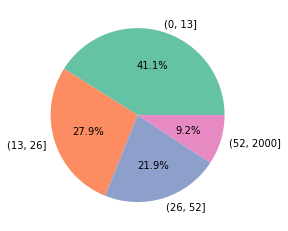

In [12]:
anime_episodes_count = pd.cut(anime_episodes["episodes"], [0, 13, 26, 52, 2000]).value_counts().sort_index()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.pie(anime_episodes_count.values, labels=anime_episodes_count.index, autopct="%1.1f%%")
plt.show()

## 4. 아이템 기반 추천 / アイテムベースレコメンド

- Convert to sparse matrix because most of the values in the cross tabulation table created above are zero.
- Since this is an item-based recommendation, it is necessary to transpose rows and columns.

In [14]:
features_sparse = csr_matrix(features_df.T.values)
features_sparse.shape

(11197, 73515)

### Calculation of cosine similarity

In [15]:
cos_sim = cosine_similarity(features_sparse)
cos_sim.shape

(11197, 11197)

In [17]:
cos_sim_df = pd.DataFrame(cos_sim, index=features_df.columns, columns=features_df.columns)
cos_sim_df.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34283,34324,34325,34349,34358,34367,34412,34475,34476,34519
anime_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.618576,0.550734,0.271236,0.078021,0.154346,0.250615,0.079702,0.185073,0.311073,...,0.014124,0.007756,0.009016,0.014459,0.007928,0.011108,0.0,0.009245,0.007928,0.007928
5,0.618576,1.000000,0.429094,0.264380,0.063928,0.098473,0.213687,0.058323,0.151804,0.244163,...,0.015984,0.012121,0.010998,0.018704,0.011873,0.016017,0.0,0.004673,0.011873,0.011873
6,0.550734,0.429094,1.000000,0.289335,0.105946,0.188664,0.227400,0.100369,0.205040,0.264846,...,0.017521,0.015425,0.005097,0.021691,0.009323,0.012562,0.0,0.006256,0.009323,0.009323
7,0.271236,0.264380,0.289335,1.000000,0.096508,0.091940,0.183552,0.075281,0.117069,0.163618,...,0.004234,0.010556,0.003740,0.022363,0.018866,0.016596,0.0,0.000000,0.018866,0.018866
8,0.078021,0.063928,0.105946,0.096508,1.000000,0.163774,0.074971,0.129833,0.093899,0.065142,...,0.000000,0.007040,0.010241,0.036563,0.047794,0.037285,0.0,0.000000,0.047794,0.047794


### Recommend animations similar to the animation specified

- Create a function that recommends animations with high similarity.
- It is useless to recommend unpopular animations, so set the threshold for the members.

In [18]:
def recommend_animes(anime_df, cos_sim_df, anime_name, top_n=10, members_threshold=10000):
    anime_id = anime_df.loc[anime_df["name"] == anime_name, "anime_id"].values[0]
    similarities = cos_sim_df[anime_id]
    rec_anime_ids = similarities.sort_values(ascending=False).index
    rec_anime_names = []
    rec_anime_similarity = []
    
    count = 0
    for i in rec_anime_ids:
        data = anime_df.loc[anime_df["anime_id"] == i, :]
        if (i != anime_id) and (data["members"].values[0] >= members_threshold):
            rec_anime_names.append(data["name"].values[0])
            rec_anime_similarity.append(similarities[i])
            count += 1
        if count >= top_n:
            break
    result = pd.DataFrame({"anime_name": rec_anime_names, "cosine_similarity": rec_anime_similarity})
    
    return result

- As a result of entering the 「SLAM DUNK」, sports animations such as 「はじめの一歩」 and 「MAJOR」 were recommended.

In [19]:
recommend_animes(anime_df, cos_sim_df, "Slam Dunk")

,anime_name,cosine_similarity
0,Hajime no Ippo,0.319749
1,Hunter x Hunter,0.306693
2,Hajime no Ippo: New Challenger,0.294562
3,Eyeshield 21,0.272062
4,Major S1,0.264972
5,One Outs,0.264971
6,Great Teacher Onizuka,0.261571
7,Major S3,0.259047
8,Major S2,0.258226
9,Major S4,0.256709


- For 「けいおん!」, the same series was ranked high.
- Similar animations such as 「涼宮ハルヒの憂鬱」 and 「とらドラ！」 were also recommended.

In [20]:
recommend_animes(anime_df, cos_sim_df, "K-On!")

,anime_name,cosine_similarity
0,K-On!!,0.758952
1,K-On! Movie,0.544009
2,Suzumiya Haruhi no Yuuutsu,0.519642
3,Toradora!,0.518425
4,K-On!: Live House!,0.517225
5,Lucky☆Star,0.500133
6,Clannad,0.485178
7,Angel Beats!,0.479917
8,Ore no Imouto ga Konnani Kawaii Wake ga Nai,0.477393
9,Clannad: After Story,0.459823


## 5. 사용자 기반 추천 / ユーザーベースレコメンド

### Extract similar users

- When you attempt to calculate the cosine similarity between users, the MemoryError occurs on the local PC.
- First, use the NearestNeighbors of the scikit-learn to restrict to close users.

In [8]:
knn = NearestNeighbors(n_neighbors=30, algorithm="brute", metric="cosine")
model = knn.fit(csr_matrix(features_df.values))

- For example, you can extract users who are close to user_id=12.

In [9]:
user_id = 12
user_rating = features_df.loc[features_df.index == user_id, :]
neighbors_index = model.kneighbors(user_rating.values.reshape(1, -1), return_distance=False)
neighbors_index = sorted(neighbors_index.flatten())
neighbors_id = features_df.iloc[neighbors_index, :].index.values
neighbors_id

array([   12,   752,  1288,  3139,  3772,  8834, 10169, 11674, 12870,
       13102, 14535, 15827, 16562, 16702, 18555, 19279, 22787, 32245,
       32904, 37838, 39706, 46045, 46289, 46735, 63468, 64177, 64839,
       67611, 69107, 72372], dtype=int64)

### Calculation of cosine similarity

- Limit it to nearby users and calculate cosine similarity.

In [10]:
neighbors_rating = features_df.loc[features_df.index.isin(neighbors_id), :]
cos_sim_df = pd.DataFrame(cosine_similarity(neighbors_rating), index=neighbors_id, columns=neighbors_id)
cos_sim_df.head()

,12,752,1288,3139,3772,8834,10169,11674,12870,13102,...,39706,46045,46289,46735,63468,64177,64839,67611,69107,72372
12,1.000000,0.497004,0.525801,0.508586,0.485041,0.579840,0.569757,0.495679,0.523896,0.558862,...,0.493736,0.489243,0.484611,0.509965,0.523627,0.530238,0.539604,0.520273,0.565412,0.535455
752,0.497004,1.000000,0.533413,0.496891,0.615943,0.672300,0.484743,0.435488,0.201905,0.456320,...,0.246563,0.526732,0.459602,0.444742,0.447437,0.543876,0.392340,0.287696,0.518628,0.354607
1288,0.525801,0.533413,1.000000,0.682704,0.601820,0.665496,0.396875,0.443579,0.299880,0.499230,...,0.409794,0.807427,0.513786,0.456318,0.536425,0.535162,0.525686,0.477668,0.603730,0.488570
3139,0.508586,0.496891,0.682704,1.000000,0.547760,0.630798,0.409479,0.466509,0.309856,0.530142,...,0.292018,0.610745,0.408949,0.471366,0.682838,0.491988,0.500849,0.378821,0.654973,0.498456
3772,0.485041,0.615943,0.601820,0.547760,1.000000,0.659845,0.365025,0.553403,0.349746,0.404049,...,0.403511,0.745356,0.505549,0.445076,0.485269,0.584213,0.404047,0.289346,0.563062,0.517870


### Calculate the score for each animation

- Define the weighted average of the rating weighted by the cosine similarity as score.

$$
score = \frac{\sum sim_i \times rating_i}{\sum sim_i}
$$

- First, calculate values corresponding to the numerator in the above formula.

In [11]:
neighbors_sim = cos_sim_df[user_id].values
neighbors_weighted_rating = neighbors_rating.apply(lambda x: x * neighbors_sim)
neighbors_weighted_rating.head()

anime_id,1,5,6,7,8,15,16,17,18,19,...,34283,34324,34325,34349,34358,34367,34412,34475,34476,34519
user_id,,,,,,,,,,,,,,,,,,,,,
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- Then, caculate the scores by dividing them by the sum of cosine similarity.

In [12]:
scores = neighbors_weighted_rating.sum() / neighbors_sim.sum()
scores_df = pd.DataFrame(scores.fillna(0).sort_values(ascending=False), columns=["score"]).reset_index()
scores_df.head()

,anime_id,score
0,1575,9.210227
1,2904,8.832095
2,1535,8.191475
3,16498,5.998251
4,5114,5.972790


### Recommend animations that the specified user has never seen

- Recommend animations in order of score
- However, the recommended animations are limited to those that the specified user has never seen before.
- The function of the processing so far is as follows.

In [8]:
def fit_model(features_df, n_neighbors=30):
    features_sparse = csr_matrix(features_df.values)
    knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute", metric="cosine")
    model = knn.fit(features_sparse)
    return model

In [9]:
def recommend_animes(model, anime_df, features_df, user_id, top_n=10, members_threshold=10000):
    user_rating = features_df.loc[features_df.index == user_id, :]
    neighbors_index = model.kneighbors(user_rating.values.reshape(1, -1), return_distance=False).flatten()
    neighbors_id = features_df.iloc[neighbors_index, :].index.values
    
    neighbors_rating = features_df.loc[features_df.index.isin(neighbors_id), :]
    cos_sim_df = pd.DataFrame(cosine_similarity(neighbors_rating), index=neighbors_id, columns=neighbors_id)
    neighbors_sim = cos_sim_df[user_id].values
    neighbors_weighted_rating = neighbors_rating.apply(lambda x: x * neighbors_sim)
    
    scores = neighbors_weighted_rating.sum() / neighbors_sim.sum()
    scores_df = pd.DataFrame(scores.fillna(0).sort_values(ascending=False), columns=["score"]).reset_index()
    
    seen_by_user = [col for col in user_rating.columns if user_rating[col].values[0] > 0]
    result = scores_df[~scores_df["anime_id"].isin(seen_by_user)]
    
    famous_animes = anime_df.loc[anime_df["members"] >= members_threshold, ["anime_id", "name"]]
    result = pd.merge(result, famous_animes, on="anime_id")
    result = result.loc[result["score"] > 0, ["name", "score"]][:top_n]
    
    return result

In [10]:
model = fit_model(features_df)

- Recommend user_id=12.
- First, let's check out the animations that the user rated highly.

In [13]:
def seen_by_user(anime_df, ratings_df, user_id):
    seen_by_user = ratings_df.loc[ratings_df["user_id"] == user_id, :]
    seen_by_user = seen_by_user.groupby("anime_id").agg(avg_rating=("rating", "mean")).reset_index()
    seen_by_user = pd.merge(seen_by_user, anime_df[["anime_id", "name"]], on="anime_id")
    seen_by_user = seen_by_user[["name", "avg_rating"]].sort_values(by="avg_rating", ascending=False)
    return seen_by_user

In [15]:
seen_by_user(anime_df, ratings_df, user_id=12).head()

,name,avg_rating
11,Code Geass: Hangyaku no Lelouch R2,10
7,Death Note,10
19,Steins;Gate,10
9,Code Geass: Hangyaku no Lelouch,10
21,Shingeki no Kyojin,10


- Recommendations were made in the order of the scores, but the meaning is not understood.

In [16]:
recommend_animes(model, anime_df, features_df, user_id=12)

,name,score
0,Naruto,3.047321
1,Fullmetal Alchemist,2.357711
2,Bleach,1.160244
3,Fairy Tail,1.116817
4,Mirai Nikki (TV),0.956947
5,Psycho-Pass,0.832703
6,Katekyo Hitman Reborn!,0.807769
7,High School DxD,0.774282
8,Samurai Champloo,0.767559
9,Tokyo Ghoul,0.646574


- In addition, let's recommend user_id=9 who rated only one animation.

In [17]:
seen_by_user(anime_df, ratings_df, user_id=9).head()

,name,avg_rating
0,Lucky☆Star,8


- The other series of 「らき☆すた」 was recommended at the top of the list, so a plausible result was obtained.

In [18]:
recommend_animes(model, anime_df, features_df, user_id=9)

,name,score
0,Lucky☆Star: Original na Visual to Animation,0.657457
1,Cowboy Bebop,0.552971
2,K-On!,0.509743
3,Death Note,0.486417
4,Shakugan no Shana,0.261572
5,Shimoneta to Iu Gainen ga Sonzai Shinai Taikut...,0.261572
6,Kaichou wa Maid-sama!,0.249011
7,Strike Witches,0.240195
8,Danna ga Nani wo Itteiru ka Wakaranai Ken,0.226169
9,Zero no Tsukaima,0.224229
